In [1]:
import glob
import sys
from tqdm import tqdm
from PIL import Image
from os import path
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import time
import csv
import random
import pandas as pd
import math

from tqdm.notebook import tqdm

from multiprocessing import Process, Queue, cpu_count
import bearfacelabeling.predict

/home/chouffe/fruitpunch/challenges/bear/vendors/GroundingDINO/groundingdino/models/GroundingDINO/ms_deform_attn.py:31: UserWarning: Failed to load custom C++ ops. Running on CPU mode Only!
  warnings.warn("Failed to load custom C++ ops. Running on CPU mode Only!")


In [2]:
print(f'{cpu_count()} cpus')

8 cpus


In [3]:
input_dir = '../../data/01_raw/Hack the Planet'

sub_dirs = [
    '../../data/01_raw/Hack the Planet/images/Bison - bears only',
    '../../data/01_raw/Hack the Planet/images/Season1 -  bears only',
    '../../data/01_raw/Hack the Planet/images/Season2 - bears only',
    '../../data/01_raw/Hack the Planet/images/Season3 - bears only',
    '../../data/01_raw/Hack the Planet/images/Season5 - bears only',
    '../../data/01_raw/Hack the Planet/images/frameOutput/data/BearFeedingPoints - bears only',
    '../../data/01_raw/Hack the Planet/images/frameOutput/data/Bison - bears only',
    '../../data/01_raw/Hack the Planet/images/frameOutput/data/Season1 -  bears only',
    '../../data/01_raw/Hack the Planet/images/frameOutput/data/Season2 - bears only',
    '../../data/01_raw/Hack the Planet/images/frameOutput/data/Season3 - bears only',
    '../../data/01_raw/Hack the Planet/images/frameOutput/data/Season5 - bears only'
]

output_dir = '../../data/07_model_output/bearbodylabeling/HackThePlanet'

## Getting all the bear images

In [4]:
image_extensions = [".jpg", ".PNG", ".JPG"]
image_paths = [ path for folder in sub_dirs for ext in image_extensions for path in glob.iglob('%s/**/*%s' % (folder, ext), recursive=True)]

print(len(image_paths))

13923


## Loading the Model

In [5]:
model_checkpoint_path = '../../data/06_models/GroundingDINO/groundingdino_swint_ogc.pth'
device = "cpu"
model = bearfacelabeling.predict.Model(model_checkpoint_path, device = device)

/home/chouffe/miniconda3/envs/fruitpunch_bears/lib/python3.9/site-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


final text_encoder_type: bert-base-uncased


## Generate annotations

In [6]:
def bbox_to_string(bbox: list[float]) -> str:
    x, y, width, height = bbox
    return f"{x} {y} {width} {height}"


def parse_bbox(s: str) -> list[float]:
    x, y, width, height = [float(x) for x in s.split(" ")]
    return [x, y, width, height]

In [7]:
bbox_to_string([0.494128555059433, 0.45449402928352356, 0.1353732794523239, 0.15825387835502625])
parse_bbox(bbox_to_string([0.494128555059433, 0.45449402928352356, 0.1353732794523239, 0.15825387835502625]))

[0.494128555059433,
 0.45449402928352356,
 0.1353732794523239,
 0.15825387835502625]

In [8]:
N = 20
subset = image_paths[:N]

In [9]:
input_dir

'../../data/01_raw/Hack the Planet'

In [10]:
def annotate(model, text_prompt: str, image_paths: list[Path], input_dir: Path, output_dir: Path) -> None:
    for image_path in tqdm(image_paths):
        
        image = Image.open(image_path)
        bbox = model.predict(image, text_prompt=text_prompt)
        
        relative_image_path = path.relpath(image_path, input_dir)
        relative_ann_path = path.splitext(relative_image_path)[0] + '.txt'
        ann_path = path.join(output_dir, relative_ann_path)
        
        # Create dir
        Path(path.dirname(ann_path)).mkdir(parents=True, exist_ok=True)
        
        with open(ann_path, 'w') as f:
            if bbox:
                f.write(bbox_to_string(bbox))

In [11]:
text_prompt = "bear"
annotate(model=model, text_prompt=text_prompt, image_paths=subset, input_dir=input_dir, output_dir=output_dir)

  0%|          | 0/20 [00:00<?, ?it/s]

/home/chouffe/miniconda3/envs/fruitpunch_bears/lib/python3.9/site-packages/transformers/modeling_utils.py:962: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/home/chouffe/miniconda3/envs/fruitpunch_bears/lib/python3.9/site-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/chouffe/miniconda3/envs/fruitpunch_bears/lib/python3.9/site-packages/torch/utils/checkpoint.py:90: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


## Visualize

In [12]:
def display_pred(bb_data, ax):
    bb = bb_data[0]
    style = bb_data[1]
    rect = patches.Rectangle(
        (bb[0], bb[1]),
        bb[2],
        bb[3],
        linewidth=2,
        facecolor='none',
        **style
    )
    ax.add_patch(rect)
    return ax


def display_image_data(image, bboxes_data, ax):
    ax.imshow(image)
    for bb_data in bboxes_data:
        display_pred(bb_data, ax)


def display_entry(entry, ax):
    image_path = path.join(input_dir, entry.img if isinstance(entry, pd.Series) else entry)
    image = Image.open(image_path)
    # print(entry)
    bbox = None

    if isinstance(entry, pd.Series) and 'bbox' in entry.index:
        bbox_v8 = entry.bbox
        image = Image.open(image_path)
        w,h = image.size

        bb_w, bb_h = bbox_v8[2]*w, bbox_v8[3]*h
        bbox = [bbox_v8[0]*w - bb_w/2, bbox_v8[1]*h - bb_h/2, bb_w, bb_h ]

    display_image_data(image,
        [(bbox,{'edgecolor': 'g'})] if bbox else []
        , ax)


def display_entries(entries, ncols = 1, figsize=10):
    fig, ax = plt.subplots(math.ceil(len(entries)/ncols), ncols, figsize=(figsize,figsize))
    ax = ax.flatten()
    for i in range(len(entries)):
        display_entry(entries.iloc[i],ax[i])
        ax[i].axis('off') 
    plt.tight_layout()
    plt.show()

In [13]:
def parse_annotations(image_paths: list[Path]) -> dict[str, pd.DataFrame]:
    anns = {}
    imgs_without_ann_file = []
    
    for img_path in image_paths:
        img_rel_path = relative_image_path = path.relpath(img_path, input_dir)
        ann_rel_path = path.splitext(img_rel_path)[0] + '.txt'
        
        try:
            with open(path.join(output_dir, ann_rel_path), 'r') as f_ann:
                content = f_ann.read()
                if not content:
                    anns[img_rel_path] = None
                else:
                    lines = content.split("\n")
                    bboxes = [parse_bbox(line) for line in lines]
                    if bboxes:
                        anns[img_rel_path] = bboxes[0]
                    else:
                        anns[img_rel_path] = None
        except FileNotFoundError as err:
                imgs_without_ann_file.append(img_rel_path)

    df_image_pb = pd.DataFrame.from_dict({'img': imgs_without_ann_file})
    df = pd.DataFrame.from_dict({'img': anns.keys(), 'bbox':anns.values()})
            
    return {"ok": df, "ko": df_image_pb}

In [14]:
d = parse_annotations(image_paths=subset)
df, df_image_pb = d["ok"], d["ko"]
df_annotated = df.dropna()
df_no_annotation = df[df['bbox'].isna()]['img']

In [15]:
df_image_pb

,img


In [16]:
df_no_annotation

Series([], Name: img, dtype: object)

### images with bbox

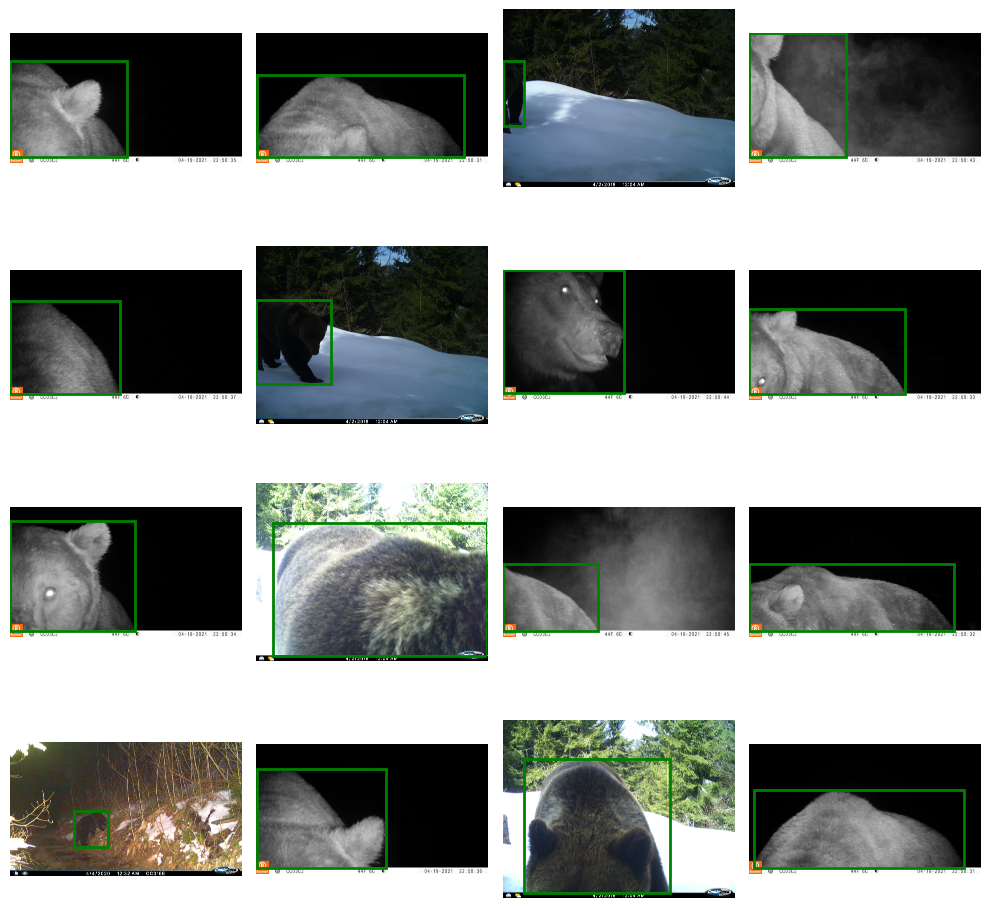

In [18]:
display_entries(df_annotated.sample(n=16), ncols=4)